# Analysis of Dynamic Systems

## Goals of this course

- **Introduce the concepts of feedback, regulation and/or control**, and some skills useful in practice.
- **To present modeling tools of linear dynamical systems invariant over time**, and the working environment of the course!!!
- **To present the behavior of systems of first order and second order**
- **To determine the stability of linear and nonlinear dynamic systems**
- **To determine the temporal response of dynamic systems**
- **Evaluate the dynamic effects of introducing different factors that influence a system**

## Schedule:

- Getting started
- PID control
 - Feedback concept
 - Structure of a PID controller
 - Proportional control
 - Integral control
 - Differential control
 - PID controller saturation and limits
 - Empirical adjustment of PID controllers

In [1]:
# Run this only in Colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
colab_path = '/content/drive/My Drive/Colab Notebooks/dynamic-ud/notebooks/img/'
my_path = 'img/'
valid_path = colab_path # Use one of them depending on the platform

In [3]:
# Run this only in Colab
# Rendering SymPy equations in Colab requires the MathJax javascript library
from IPython.display import Math, HTML

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

## Getting started

As described throughout the course, control theory focuses on dynamic systems with inputs and outputs, this basically includes physical systems whose state evolves over time based on the information they receive from the outside. Control deals with aspects of engineering and mathematics, but it also has applications in the social sciences: psychology, sociology, economics,... The fundamental element is to manage to keep the output variables within a desired range, which requires the feedback of some of the state variables of the system.

### PID control

A proportional–integral–derivative controller (PID controller or three-term controller) is a control loop mechanism employing feedback that is widely used in industrial control systems and a variety of other applications requiring continuously modulated control. A PID controller continuously calculates an error value $e(t)$ as the difference between a desired setpoint $(SP)$ and a measured process variable, and applies a correction based on proportional, integral, and derivative terms (denoted $P$, $I$, and $D$ respectively), hence the name.

In practical terms it automatically applies accurate and responsive correction to a control function. An everyday example is the *cruise control on a car*, where ascending a hill would lower speed if only constant engine power were applied. The controller's PID algorithm restores the measured speed to the desired speed with minimal delay and overshoot by increasing the power output of the engine.

#### Feedback concept

The feedback allows the controller to determine how far the output variable is from the desired state, i.e. to determine its error $e(t)$. Let's look at an example step by step to better understand the concept. As an example, let's consider the classic case of cruise control on a car.

Let's assume that our plant is the cruise control of a car. We can outline the problem as follows:

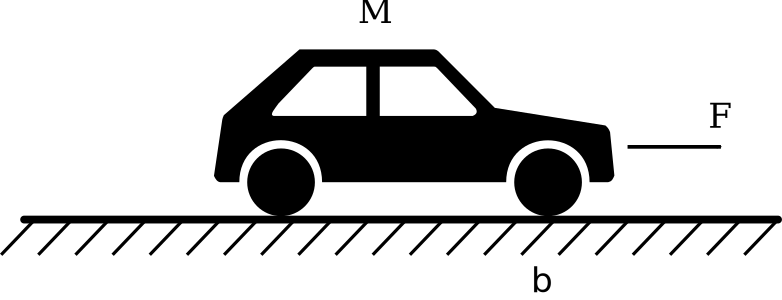

In [27]:
from IPython.display import SVG
SVG(valid_path + 'pid1.svg')

Cruise control (speed control, auto-cruise o tempomat) is a system that automatically controls the speed of a motor vehicle. The system takes over the throttle of the car to maintain a steady speed as set by the driver. So, it's a speed control.

The model of this plant is as follows:

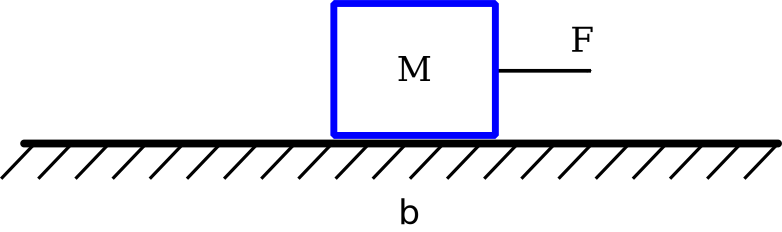

In [28]:
SVG(valid_path + 'pid2.svg')

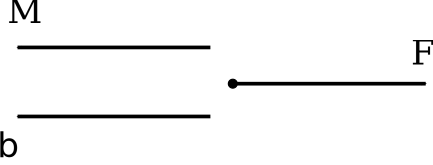

In [29]:
SVG(valid_path + 'pid3.svg')

$$M\frac{dv\left(t\right)}{dt}+\beta\,v\left(t\right)=F\left(t\right)$$

The input of our system will be the applied traction force, and the output or variable that we want to control will be the speed. The transfer function will be:

$$M\,s\,V\left(s\right)+\beta\,V\left(s\right)=F\left(s\right)$$

$$\frac{V\left(s\right)}{F\left(s\right)}=G\left(s\right)=\frac{1}{M\,s+\beta}$$

In [30]:
SVG(valid_path + 'pid4.svg')

Let's take the following values for the system constants, and define it as LTI:

In [31]:
from scipy import signal

M = 1200  # kg
b = 75  # Ns / m
sys_car = signal.lti(1, [M, b])

What speed would be reached in open loop if the motor applies a force of 2300 N? Let us then look at the response to the unitary step with this value of force as input:

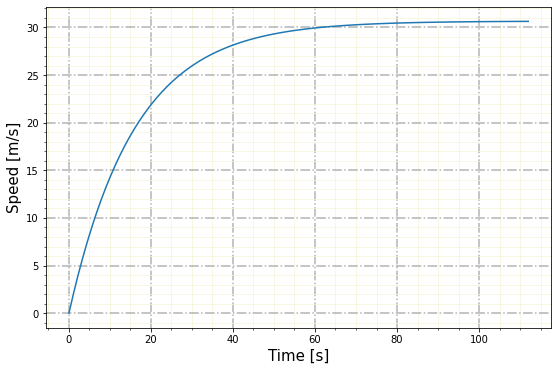

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

t, y = signal.step2(sys_car) # Single step response
plt.rcParams['figure.figsize'] = [23/2.54, 15/2.54] # Size adjustment, 23 cm x 15 cm
plt.plot(t, 2300 * y) # Equivalent to an input height of 2300 N

plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Speed [m/s]', fontsize=15)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5) # Mayor grid lines
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1) # Minor grid lines
plt.minorticks_on()

With this input the system would reach a little more than 30 m/s, a very low speed.

Now let's implement the following control scheme for the plant:

In [33]:
SVG(valid_path + 'pid5.svg')

In this case we have a closed loop by means of a feedback, and we have included the control block (in the previous case there was also control, and it was in charge of injecting the input signal $u(t)$ but without knowing the behaviour of the output).

The error signal is the difference between the reference value and the sample of the output signal through a sensor with $k$-gain.

#### Structure of a PID controller

PID control combines a proportional, integral and derivative action on the error signal $e(t)$ to produce the input signal to the plant $u(t)$. The equation for such a controller is:

$$u\left(t\right)=K_{P}e\left(t\right)+K_{I}\int e\left(t\right)\,dt+K_{D}\frac{d\,e\left(t\right)}{dt}$$

Therefore its transfer function is:

$$H\left(s\right)=\frac{u\left(s\right)}{e\left(s\right)}=K_{P}+\frac{K_{I}}{s}+sK_{D}$$

$$H\left(s\right)=\frac{u\left(s\right)}{e\left(s\right)}=K_{P}+\frac{K_{I}}{s}+sK_{D}=K_{P}\left(1+\frac{1}{s\,T_{i}}+s\,T_{d}\right)$$

where $T_i$ is called integral time and $T_d$ is the derivative time.

Each of these terms contributes in a different way to the control system, and the correct weighting of each of these contributions is what we will have to look for in order to achieve the desired solution. This process is called PID controller tuning.

For the cases we are going to analyze we are going to assume that the sensor has a gain of $K = 1$.

#### Proportional control

In [34]:
SVG(valid_path + 'pid6.svg')

The simplest form of control is when the control signal $u(t)$ is proportionally dependent on the error $e(t)$. That is, the integral and derivative constants are zero:

$$\frac{y\left(s\right)}{r\left(s\right)}=\frac{y\left(s\right)}{y\left(s\right)+e\left(s\right)}=\frac{K_{P}G\left(s\right)}{1+K_{P}G\left(s\right)}=\frac{K_{P}\frac{1}{Ms+\beta}}{1+K_{P}\frac{1}{Ms+\beta}}=\frac{K_{P}\frac{1}{Ms+\beta}}{\frac{\left(Ms+\beta\right)+K_{P}}{Ms+\beta}}=\frac{K_{P}}{Ms+\beta+K_{P}}
$$

SciPy does not provide a direct mode of operating with blocks, so we will write our own functions for that purpose. To do this, we will operate the transfer functions of the systems as fractions, extracting the numerator and denominator separately and using the NumPy functions $np.polymul$ and $np.polyadd$.

In [35]:
def series(sys1, sys2):
    """Series connection of two systems""" 
    if not isinstance(sys1, signal.lti):
        sys1 = signal.lti(*sys1)
    if not isinstance(sys2, signal.lti):          
        sys2 = signal.lti(*sys2)
    num = np.polymul(sys1.num, sys2.num)     
    den = np.polymul(sys1.den, sys2.den)     
    sys = signal.lti(num, den) 
    return sys
 
def feedback(plant, sensor=None):       
    """Negative feedback connection of plant and sensor. 
       If sensor is None, then it is assumed to be 1""" 
    if not isinstance(plant, signal.lti):         
        plant = signal.lti(*plant) 
    if sensor is None: 
        sensor = signal.lti([1], [1]) 
    elif not isinstance(sensor, signal.lti):         
        sensor = signal.lti(*sensor) 
    num = np.polymul(plant.num, sensor.den)     
    den = np.polyadd(
        np.polymul(plant.den, sensor.den),                      
        np.polymul(plant.num, sensor.num)
    ) 
    sys = signal.lti(num, den)
    return sys

We already have the plant stored in *sys_car*, we multiply it with the control block, our proportional block with $K_P$ numberer, and denominator $1$.

$$K_{P}=200\;\textrm{and}\;G\left(s\right)=\frac{1}{Ms+\beta}$$

In [36]:
import numpy as np
Kp = 200

sys_pc = series(([Kp], [1]), sys_car) # [Proportional block] * [Plant]
sys_prop = feedback(sys_pc) # Feedback

# Step response
t = np.linspace(0, 60, num=10000)
t, y = signal.step2(sys_prop, T=t)
plt.plot(t, y)
plt.plot([0, t[-1]], [1] * 2, 'k--')

# Labels and grid
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Speed [m/s]', fontsize=15)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5) # Mayor grid lines
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1) # Minor grid lines
plt.minorticks_on()

The rise time is about 20 seconds (instead of the minute earlier), but the output does not reach the level we want. This is because the proportional controllers introduce a certain error in steady state $e_{ss}$. For our system, the value of this error is:

$$e_{ss}=\underset{t\longrightarrow\infty}{lim}\:e\left(t\right)=\frac{1}{1+\frac{K_{P}}{\beta}}$$

It seems logical to think that we should then increase the $K_P$ to reduce the error. If for example $K_P =$ 2000

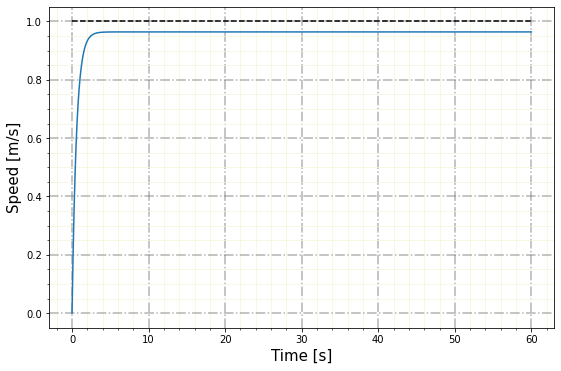

In [40]:
import numpy as np
Kp = 2000

sys_pc = series(([Kp], [1]), sys_car) # [Proportional block] * [Plant]
sys_prop = feedback(sys_pc) # Feedback

# Step response
t = np.linspace(0, 60, num=10000)
t, y = signal.step2(sys_prop, T=t)
plt.plot(t, y)
plt.plot([0, t[-1]], [1] * 2, 'k--')

# Labels and grid
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Speed [m/s]', fontsize=15)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5) # Mayor grid lines
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1) # Minor grid lines
plt.minorticks_on()

Now the rise time is less than 5 seconds and the steady state error is $e_{ss} \simeq$ 3.6. The output is close to the input signal, follows it much more closely and with a much shorter rise time. However, you cannot increase the proportional gain indefinitely because that means increasing the motor power indefinitely.

#### Integral control

The disadvantage of proportional control is that, if the error signal tends to zero, the control signal tends to zero as well. With the integral term we can add a contribution that depends on the area enclosed under the curve of the error signal, and thus eliminate the error in steady state. The integral component eliminates steady-state error and reduces time rise, but increases system instability. Now our scheme would look like this:

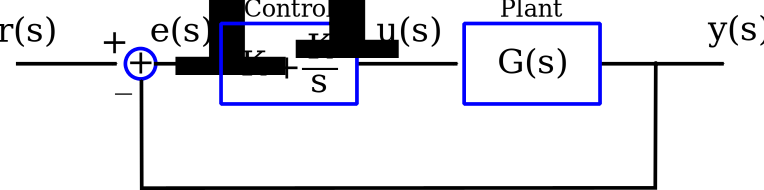

In [17]:
SVG(valid_path + 'pid7.svg')

And the transfer function is:

$$\frac{y\left(s\right)}{r\left(s\right)}=\frac{y\left(s\right)}{y\left(s\right)+e\left(s\right)}=\frac{\left(K_{P}+\frac{K_{I}}{s}\right)G\left(s\right)}{1+\left(K_{P}+\frac{K_{I}}{s}\right)G\left(s\right)}
$$

$$\frac{y\left(s\right)}{r\left(s\right)}=\frac{\left(\frac{sK_{P}+K_{I}}{s}\right)\left(\frac{1}{Ms+\beta}\right)}{1+\left(\frac{sK_{P}+K_{I}}{s}\right)\left(\frac{1}{Ms+\beta}\right)}=\frac{\frac{sK_{P}+K_{I}}{Ms^{2}+\beta s}}{\frac{\left(Ms^{2}+\beta s\right)+\left(sK_{P}+K_{I}\right)}{Ms^{2}+\beta s}}=\frac{sK_{P}+K_{I}}{Ms^{2}+\left(\beta+K_{P}\right)s+K_{I}}
$$

As you can see, the transfer function of the controller is now second order, this produces some new effects, as you can see in the graph of the unitary step response of the system. To observe this, let us initially assume the following values for the constants: $K_P$= 200 and $K_I=$ 50.

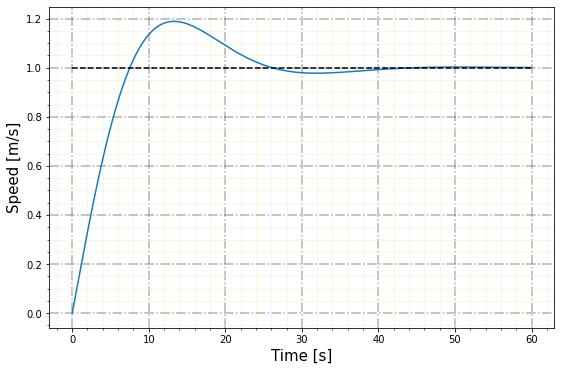

In [45]:
import numpy as np
Kp = 200.0
Ki = 50.0

sys_pc = series(([Kp, Ki], [1, 0]), sys_car) # [PI block] * [Plant]
sys_prop = feedback(sys_pc) # Feedback

# Step response
t = np.linspace(0, 60, num=10000)
t, y = signal.step2(sys_prop, T=t)
plt.plot(t, y)
plt.plot([0, t[-1]], [1] * 2, 'k--')

# Labels and grid
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Speed [m/s]', fontsize=15)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5) # Mayor grid lines
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1) # Minor grid lines
plt.minorticks_on()

We have a rise time of less than 10 seconds, but on the contrary we have introduced an oscillation in the system. In some problems this may be unacceptable, but in this case we can afford it. All we have to do is control the oscillation. For this response:
- The peak time $t_p$: 13 s
- Overshoot $M_p$: 19%

In general, we will want to adjust our control system so that it has:
- Small rise time
- Small overshoot
- No error in steady state

One thing to keep in mind is that we cannot optimise these three requirements at the same time. If we reduce the rise time, the maximum overshoot will increase, and vice versa.

We will define the following requirements for our specific case:
- Rise time: < 5 s
- Overshoot: < 10%
- Steady-state error < 2 %

We're going to write a couple of little functions that calculate these magnitudes for us:

In [46]:
def tr(t, y, ys=None, margins=(0.1, 0.9)):
    """Rise time. 
    Other possible margins: (0.05, 0.95), (0.0, 1.0). If no ys is given, 
    then last value of y is assumed as stationary. 
    """ 
    if ys is None:
        len_y = len(y)
        ys = y[len_y-1]

    y_lim1 = margins[0] * ys
    y_lim2 = margins[1] * ys
    n = 0
    m = 0

    while y_lim1 > y[n]:
        n = n + 1
    else:
        t_lim1 = t[n]

    while y_lim2 > y[m]:
        m = m + 1
    else:
        t_lim2 = t[m]
    
    t_rise = t_lim2 - t_lim1
    return t_rise
 
def Ms(y, ys=None): 
    """Maximum overshoot. 
    If no ys is given, then last value of y is assumed as stationary. 
    """ 
    if ys is None: 
        ys = y[-1] 
    ymax = np.max(y) 
    Ms = (ymax - ys) / ys 
    return Ms

Now let's check again the answer for $K_P=$ 700 and $K_I=$ 100.

Rise time: 2.91 s
Overshoot: 6.3 %


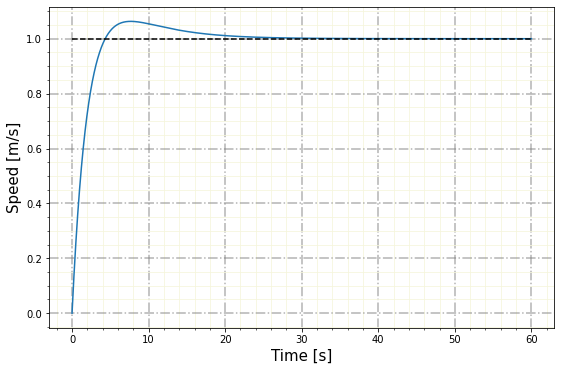

In [47]:
import numpy as np
Kp = 700.0
Ki = 100.0

sys_pc = series(([Kp, Ki], [1, 0]), sys_car) # [PI block] * [Plant]
sys_prop = feedback(sys_pc) # Feedback

# Step response
t = np.linspace(0, 60, num=10000)
t, y = signal.step2(sys_prop, T=t)
plt.plot(t, y)
plt.plot([0, t[-1]], [1] * 2, 'k--')

# Labels and grid
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Speed [m/s]', fontsize=15)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5) # Mayor grid lines
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1) # Minor grid lines
plt.minorticks_on()

print("Rise time: {:.2f} s".format(tr(t, y)))
print("Overshoot: {:.1f} %".format(Ms(y) * 100))

We have already met the design requirements of the controller, so we would not have to add a derivative term, but we will add it. It will have the effect of smoothing the response, but it has an important counterpart, in the presence of noise it can destabilize the system.

#### Differential control

The differential part is a way of looking at the speed of the error. When the system moves at high speed towards the reference, an overshoot occurs. To avoid this problem the controller must recognize the speed at which the system grows, which is the effect of the differential component. Although it does not alter the steady state error, if it decreases the time rise

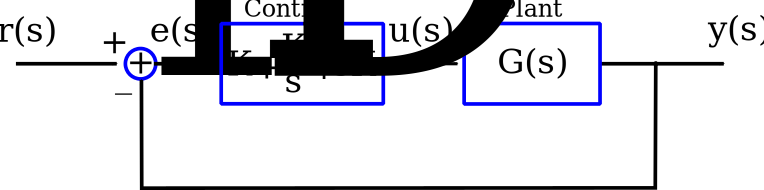

In [48]:
SVG(valid_path + 'pid8.svg')

And the transfer function is:

$$\frac{y\left(s\right)}{r\left(s\right)}=\frac{y\left(s\right)}{y\left(s\right)+e\left(s\right)}=k\frac{\left(K_{P}+\frac{K_{I}}{s}+sK_{D}\right)G\left(s\right)}{1+\left(K_{P}+\frac{K_{I}}{s}+sK_{D}\right)G\left(s\right)}
$$

$$\frac{y\left(s\right)}{r\left(s\right)}=\frac{\left(\frac{sK_{P}+K_{I}+s^{2}K_{D}}{s}\right)\left(\frac{1}{Ms+\beta}\right)}{1+\left(\frac{sK_{P}+K_{I}+s^{2}K_{D}}{s}\right)\left(\frac{1}{Ms+\beta}\right)}=\frac{\frac{sK_{P}+K_{I}+s^{2}K_{D}}{Ms^{2}+\beta s}}{\frac{Ms^{2}+\beta s+sK_{P}+K_{I}+s^{2}K_{D}}{Ms^{2}+\beta s}}
$$

$$\frac{y\left(s\right)}{r\left(s\right)}=\frac{s^{2}K_{D}+sK_{P}+K_{I}}{\left(M+K_{D}\right)s^{2}+\left(\beta+K_{P}\right)s+K_{I}}$$

Again a controller with a second order structure is obtained, but in this case the numerator is also second order.

Based on the above setting of the PI controller, let us evaluate the system response for the following values: $K_P=$ 700, $K_I=$ 100, and $K_D=$ 200.

Rise time: 3.38 s
Overshoot: 6.1 %


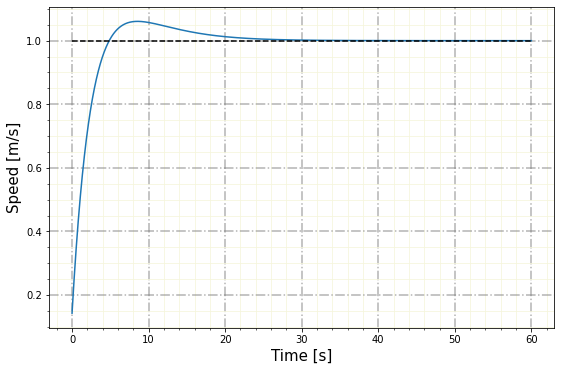

In [49]:
import numpy as np
Kp = 700.0
Ki = 100.0
Kd = 200.0

sys_pc = series(([Kd, Kp, Ki], [1, 0]), sys_car) # [PID block] * [Plant]
sys_prop = feedback(sys_pc) # Feedback

# Step response
t = np.linspace(0, 60, num=10000)
t, y = signal.step2(sys_prop, T=t)
plt.plot(t, y)
plt.plot([0, t[-1]], [1] * 2, 'k--')

# Labels and grid
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Speed [m/s]', fontsize=15)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5) # Mayor grid lines
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1) # Minor grid lines
plt.minorticks_on()

print("Rise time: {:.2f} s".format(tr(t, y)))
print("Overshoot: {:.1f} %".format(Ms(y) * 100)) #6.1%

As it can be seen, the overshoot is reduced a little, but at the meantime the response time rise is increased.

#### PID controller saturation and limits

In real systems there are limitations that reduce the controller's ability to achieve the desired response. No matter how much the proportional action is increased, there will come a time when the actuator will become saturated and unable to give more. For example, in a temperature control system, the heating resistor will be able to deliver power up to 2000 watts. If the controller tries to deliver more power to achieve a higher heating rate, it will not be able to and the system will not achieve a higher rate. Even if the proportional control action is increased the 2000 watt actuator limit limits the maximum heating speed. Therefore it should be noted that the response speed of real systems has certain limits that the control cannot exceed.

#### Empirical adjustment of PID controllers

These methods, referred to as classical, began to be used around 1950, and are based on measurements made on the actual plant.

- **Ziegler-Nichols Oscillation Method**. This method is only valid for stable open-loop plants. The procedure is as follows:
 - Apply only proportional control with small $K_P$ gain to the plant.
 - Increase the $K_P$ value until the loop starts to oscillate. The oscillation must be linear and must be detected at the controller output $u(t)$.
 - Record the critical gain $K_P$ = $K_C$ and the period of oscillation $P_C$ of $u(t)$, at the controller output.
 - Set the PID controller parameters according to the table below:


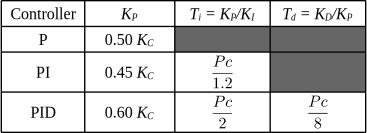

In [50]:
SVG(valid_path + 'pid9.svg')

It is important to know the structure (standard, serial or parallel) of the PID to which the adjustment proposed by Ziegler and Nichols applies. There is some controversy as to which structure was originally used by Ziegler and Nichols; the rules given here are proposed for the standard structure.

- **Ziegler-Nichols reaction curve method**. A quantitative linearized version of the Ziegler-Nichols method assumes a linear-type plant whose model can be obtained by an open-loop experiment with the following procedure:
 - Manually take the open-loop plant to a normal operating point by handling $u(t)$. Assume that the plant is stabilized at $y(t) = y_0$ for $u(t) = u_0$.
 - At an initial moment $t_0$ apply a step change at the input, from $u_0$ to $u_{\infty}$ (the jump must be between 10 and 20% of the nominal value.
 - Record the output response until the new operating point is stabilized. The following figure shows a typical curve.
 - Calculate the model parameters from the formulas

$$G_{0}\left(s\right)=\frac{k_{0}e^{-s\tau_{0}}}{\gamma_{0}s+1}\quad,\quad\gamma_{0}>0$$

$$k_{0}=\frac{y_{\infty}-y_{0}}{u_{\infty}-u_{0}},\quad\tau_{0}=t_{1}-t_{0},\quad\gamma_{0}=t_{2}-t_{1}$$

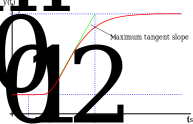

In [51]:
SVG(valid_path + 'pid10.svg')

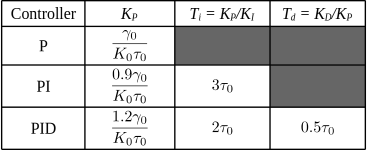

In [52]:
SVG(valid_path + 'pid11.svg')

- **Cohen-Coon reaction curve method**. The Ziegler and Nichols setting for the reaction curve is very sensitive to $t$/$g_0$ variations. Cohen and Coon developed a modified table to improve this limitation using data from the same test.

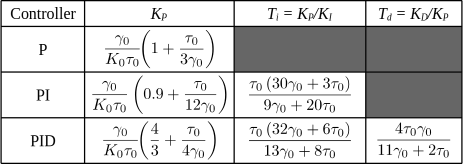

In [ ]:
SVG(valid_path + 'pid12.svg')

## Root Locus

In [53]:
!pip install control

$$G(s)=\frac{1}{Ms+\beta}=\frac{1}{1200s+75}$$

In [59]:
import numpy as np
from matplotlib import pyplot as plt 
import control

%matplotlib

G = control.TransferFunction((1), (1, 2, 1))

rlist, klist = control.rlocus(G)

plt.show()

Using matplotlib backend: agg
